<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v8: Productionising Activity capturing and visualisation
This notebook carries on from v5 with work to productionise the capture and display of unit activation information.

It uses a simple callback, and starts simple with its data collection.

In [322]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout c4f0bfe
!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at 19f1baf Unit activity collection and visualisation
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 4), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 884 bytes | 126.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   19f1baf..937c6e9  main       -> origin/main
Updating 19f1baf..937c6e9
Fast-forward
 toolkit.py | 49 ++++++++++++++++---------------------------------
 1 file changed, 16 insertions(+), 33 deletions(-)


<module 'toolkit' from '/content/repo/toolkit.py'>

In [144]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


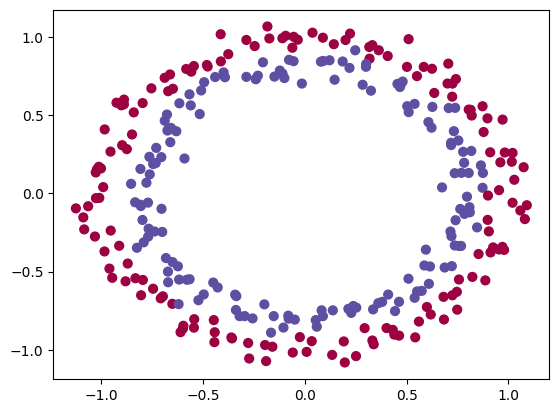

In [9]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Unit Activation Rates
Firstly, we're interested not in the floating point range of unit outputs, but rather whether the units are "active" or not. Determined simply by whether the ReLU unit passes the value through, or drops the output and returns `0.0`. For other other activation functions a unit is always considered "active", and that's fine.

In this first cut there's two measures of unit activity that we'll use:
* fraction of "dead units"
  * The percentage of units that are never active - always produce `0.0` as output.
  * This is across all items in the entire training dataset (eg: across all batches).
  * This is also across all spatial coordinates of any CNNs.
* mean rate of activation
  * The mean percentage of units that are active at any given moment in time - having a non-zero output.
  * This will be aggregated down to the channels dimension, and then averaged again (see below).

In both cases, we are primarily interested in the effect on gradient propagation. This means that we treat the tensor axis with a particular interpretation:
* `(B, ..spatial dims.., C)` - batch, spatial, channels
* eg: Simple dense network: `(B, C)`
* eg: 2D CNN: `(B, H, W, C)`
* eg: 3D CNN: `(B, H, W, D, C)` - batch, height, width, depth, channels
* eg: Dense against CNN input - `(B, ..spatial.., C)`
* Aggregated across batch and spatial dims
* Each channel treated separately

Notice that there's precedent for this way of handling the axis in how TF Dense layers handle multi-dimensional input -- they act as a CNN with a 1x1 filter, operating as a dense network across the last axis only, and otherwise sharing weights and repeating against all other axis. In the Dense docs, it refers to treating all those earlier axis as the "batch dimensions".

In practice, as we'll be interested initially only in getting stats across the entire model and for individual layers, processing will thus go as follows:
1. Aggregate "dead units" and "mean activation" across batch and spatial dims, producing a single vector across the channels dimension only.
2. Aggregate across all batches in dataset, still producing a single vector across the channels dimension only.
3. Finally, turn into a scalar as the rates/means across the channels.

Epoch   100 - 103.71ms/epoch: loss: 0.0979  
Epoch   200 - 79.83ms/epoch: loss: 0.0178  
Epoch   300 - 55.54ms/epoch: loss: 0.0070  
Epoch   400 - 72.32ms/epoch: loss: 0.0110  
Epoch   500 - 58.51ms/epoch: loss: 0.0109  
Epoch   600 - 74.69ms/epoch: loss: 0.0617  
Epoch   700 - 58.94ms/epoch: loss: 0.0001  
Epoch   800 - 71.62ms/epoch: loss: 0.0000  
Epoch   900 - 54.05ms/epoch: loss: 0.0000  
Epoch  1000 - 71.81ms/epoch: loss: 0.0000  
Total training time: 70.38 secs


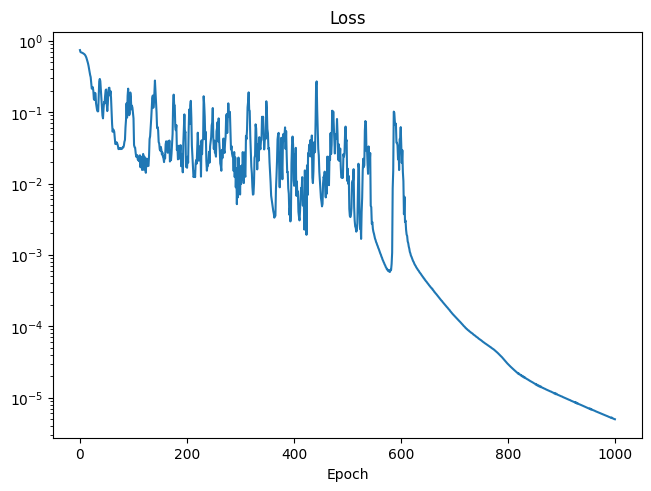

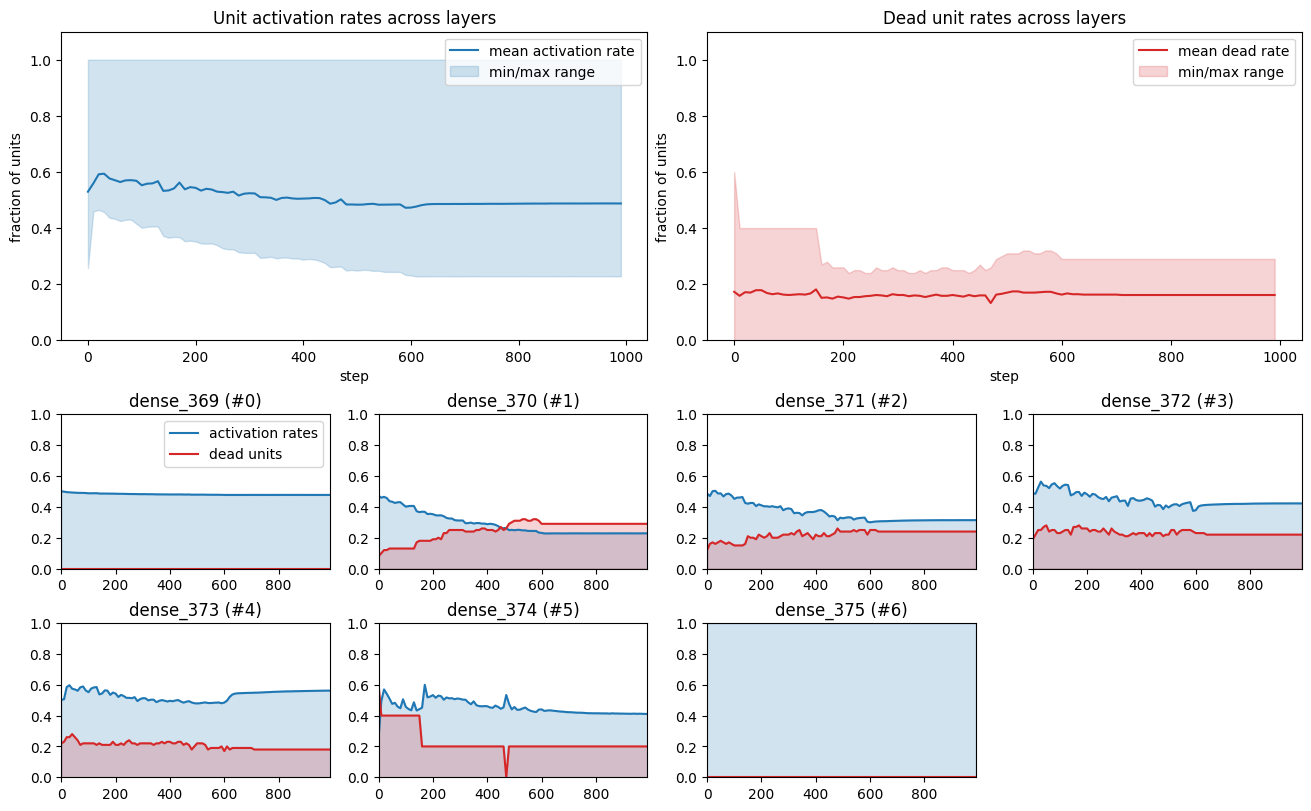

In [294]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
activity = toolkit.ActivityRateCallback(dataset, interval=10)
history = model.fit(dataset.batch(32), epochs=1000, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

activity.plot_summary()

In [295]:
model.summary()

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_369 (Dense)                    │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_370 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_371 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_372 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_374 (Dense)                    │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_375 (Dense)                    │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,635 (482.95 KB)

 Trainable params: 41,211 (160.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,424 (321.97 KB)

## MNIST Model
Now let's try against the MNIST database and model.

In [127]:
def mnist_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train_X: (60000, 28, 28), train_Y: (60000,)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8322 - loss: 0.5460
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9602 - loss: 0.1390
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9724 - loss: 0.0918
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9800 - loss: 0.0667
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9848 - loss: 0.0501
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9878 - loss: 0.0402
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9893 - loss: 0.0335
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9913 - loss: 0.0259
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9918 - loss: 0.0222
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9926 - loss: 0.0223
Total training time: 201.55 secs


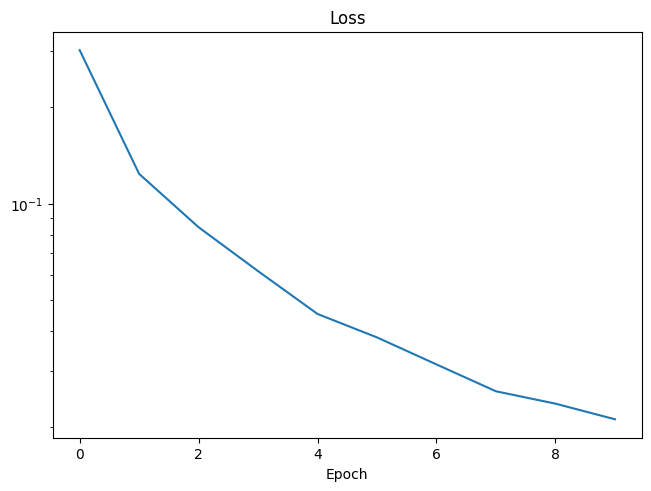

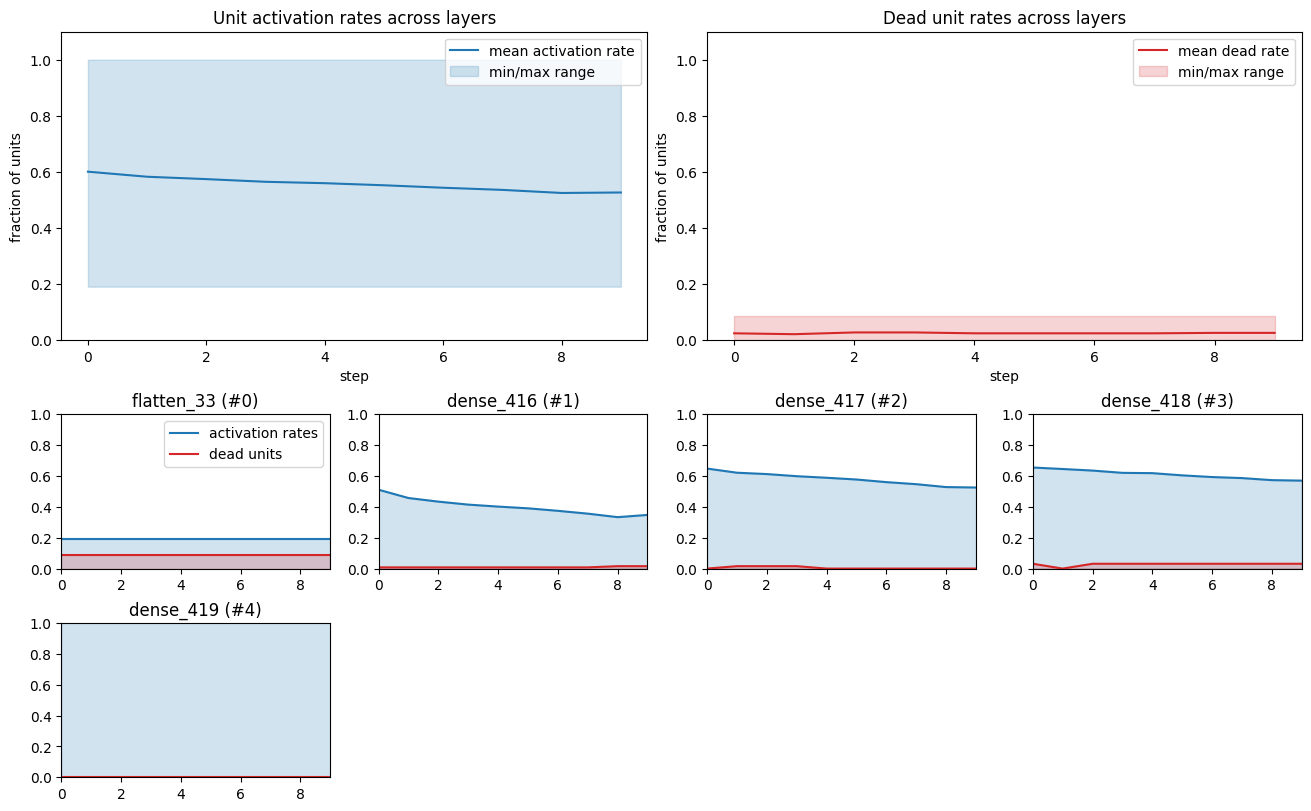

In [321]:
start = tf.timestamp()
model = mnist_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = toolkit.ActivityRateCallback(dataset)
history = model.fit(dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

for l, stats in enumerate(activity.layer_stats):
  if np.sum(stats['activation_rate'] > 1.0) > 0:
    print(f"Layer {l}: {stats['activation_rate']}")

activity.plot_summary()

In [323]:
model.summary()

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_33 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,440 (1.27 MB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 222,294 (868.34 KB)

## MNIST CNN Model
The basic MNIST model above isn't much more interesting than the 2D-linear regression problem as it only uses Dense layers.
Let's up the ante with a CNN model.

Additionally, for greater flexibility, let's split things out a little, so that it's easier to get the stats just for a single instance of a model, after training.


In [326]:
def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

train_X: (60000, 28, 28), train_Y: (60000,)


In [327]:
model = mnist_cnn_model()
model.summary()

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_11 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_424 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_425 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,570 (619.41 KB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.0625, 'mean_dead_rate': 0.0146484375, 'min_activation_rate': 0.13947405, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.4234202}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.1869021}, {'dead_rate': 0.0, 'activation_rate': 0.13947405}, {'dead_rate': 0.0, 'activation_rate': 0.29482222}, {'dead_rate': 0.0, 'activation_rate': 0.4252777}, {'dead_rate': 0.0400390625, 'activation_rate': 0.4252777}, {'dead_rate': 0.0625, 'activation_rate': 0.4921875}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([1]), TensorShape([1]), TensorShape([1])]


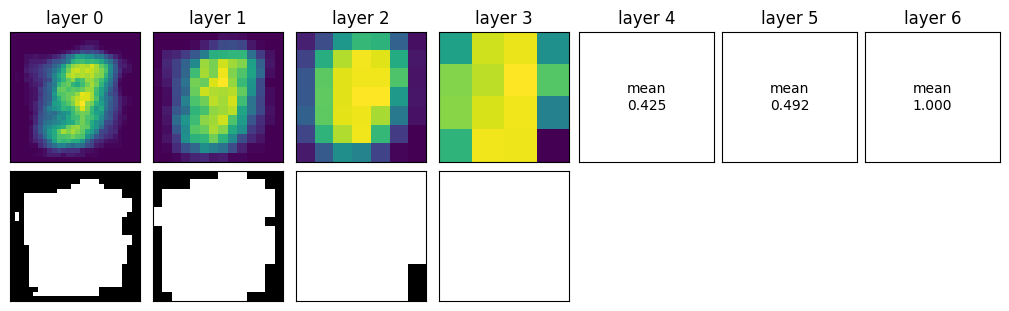

In [328]:
# Before any training
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64).take(1)
model_stats, layer_stats, layer_spatial_stats = toolkit.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

toolkit.plot_spatial_stats(layer_spatial_stats)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.8593 - loss: 0.4651
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.9763 - loss: 0.0790
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.9842 - loss: 0.0524
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - accuracy: 0.9896 - loss: 0.0351
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 79ms/step - accuracy: 0.9922 - loss: 0.0260
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.9929 - loss: 0.0216
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 69ms/step - accuracy: 0.9949 - loss: 0.0160
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.9957 - loss: 0.0145
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 0.9965 - loss: 0.0111
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.9961 - loss: 0.0114
Total training time: 748.69 secs


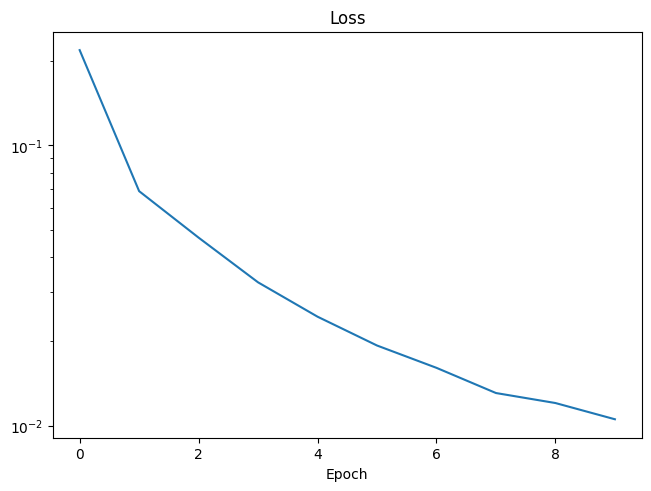

AttributeError: module 'toolkit' has no attribute 'plot_activity'

In [329]:
# After training
start = tf.timestamp()
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
activity = toolkit.ActivityRateCallback(dataset, interval=1)
history = model.fit(dataset, epochs=10, callbacks=[activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

activity.plot()

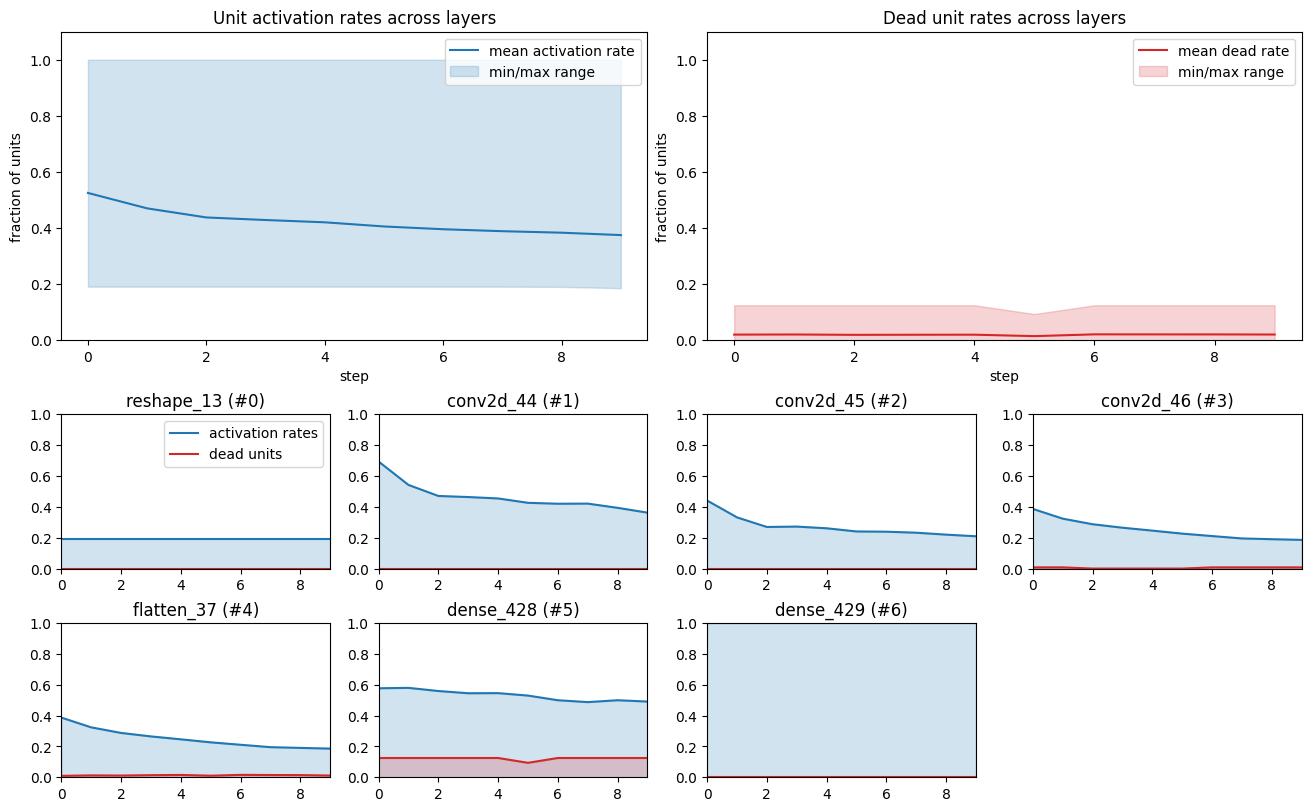

In [330]:
activity.plot()

100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


model_stats: {'min_dead_rate': 0.0, 'max_dead_rate': 0.125, 'mean_dead_rate': 0.020577566964285716, 'min_activation_rate': 0.185816, 'max_activation_rate': 1.0, 'mean_activation_rate': 0.3750297}
layer_stats: [{'dead_rate': 0.0, 'activation_rate': 0.19119719}, {'dead_rate': 0.0, 'activation_rate': 0.36241633}, {'dead_rate': 0.0, 'activation_rate': 0.20932452}, {'dead_rate': 0.0078125, 'activation_rate': 0.185816}, {'dead_rate': 0.01123046875, 'activation_rate': 0.185816}, {'dead_rate': 0.125, 'activation_rate': 0.49063778}, {'dead_rate': 0.0, 'activation_rate': 1.0}]
layer_spatial_stats: x[TensorShape([28, 28]), TensorShape([14, 14]), TensorShape([7, 7]), TensorShape([4, 4]), TensorShape([1]), TensorShape([1]), TensorShape([1])]


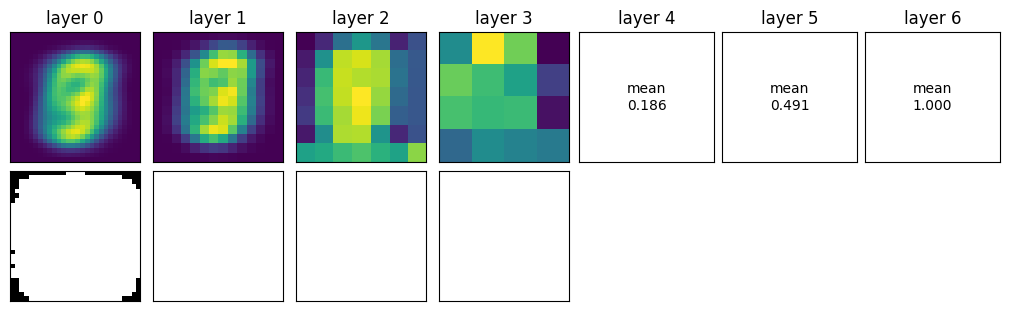

In [331]:
# and show spatial stats at end
model_stats, layer_stats, layer_spatial_stats = toolkit.measure_unit_activity(model, dataset, include_spatial_activity=True, verbose=1)
print(f"model_stats: {model_stats}")
print(f"layer_stats: {layer_stats}")
print(f"layer_spatial_stats: x{[stat.shape for stat in layer_spatial_stats]}")

toolkit.plot_spatial_stats(layer_spatial_stats)

In [332]:
model.summary()

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_13 (Reshape)                 │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_428 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_429 (Dense)                    │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,712 (1.81 MB)

 Trainable params: 158,570 (619.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 317,142 (1.21 MB)

## Appendix: Collecting stats against static model
First, let's just make sure we can cope with some variation in how data is provided.

In [30]:
def do_stuff(model, x, batch_size=None, steps_per_epoch=None):
  """
  Args:
    model: The model to evaluate.
    x: Input data or dataset
    batch_size: Batch size (at least one of this or steps_per_epoch required if x or dataset not already batched).
    steps_per_epoch: Steps per epoch, required if dataset is unbatched.
  """

  # handle variations in how data is supplied
  if isinstance(x, tf.data.Dataset):
    dataset = x
    # ensure dataset has been batched
    if not hasattr(dataset, "_batch_size"):
      if batch_size is None and steps_per_epoch is not None:
        batch_size = int(math.ceil(dataset.cardinality().numpy() / steps_per_epoch))
      if batch_size is not None:
        dataset = dataset.batch(batch_size)
      else:
        raise ValueError("dataset not batched and unable to infer batch size.")
  else:
    if batch_size is None and steps_per_epoch is not None:
      batch_size = int(math.ceil(len(x) / steps_per_epoch))
    if batch_size is None:
      raise ValueError("one of batch_size or steps_per_epoch must be provided when x list/array given.")
    y = tf.zeros((len(x),))  # fake y values
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  inputs, outputs = next(iter(dataset))
  print(f"inputs: {inputs.shape}")
  layer_outputs = monitoring_model(inputs)
  print(f"layer_outputs: {len(layer_outputs)}")

# with raw x
do_stuff(model, train_X, batch_size=32)

# with un-batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
do_stuff(model, dataset, batch_size=32)

# with batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
do_stuff(model, dataset)

inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7


Now the real work.

In [48]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,635 (482.95 KB)

 Trainable params: 41,211 (160.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,424 (321.97 KB)

In [58]:
def measure_layer_activations(model, x, batch_size=None, steps_per_epoch=None):
  """
  Args:
    model: The model to evaluate.
    x: Input data or dataset
    batch_size: Batch size (at least one of this or steps_per_epoch required if x or dataset not already batched).
    steps_per_epoch: Steps per epoch, required if dataset is unbatched.

  Returns:
    list of dict - dict of stats for each layer, containing:
      dead_rate: fraction of units that are never active
      activation_rate: mean fraction of units that are active at any given moment in time - having a non-zero output
  """

  # handle variations in how data is supplied
  if isinstance(x, tf.data.Dataset):
    dataset = x
    # ensure dataset has been batched
    if not hasattr(dataset, "_batch_size"):
      if batch_size is None and steps_per_epoch is not None:
        batch_size = int(math.ceil(dataset.cardinality().numpy() / steps_per_epoch))
      if batch_size is not None:
        dataset = dataset.batch(batch_size)
      else:
        raise ValueError("dataset not batched and unable to infer batch size.")
  else:
    if batch_size is None and steps_per_epoch is not None:
      batch_size = int(math.ceil(len(x) / steps_per_epoch))
    if batch_size is None:
      raise ValueError("one of batch_size or steps_per_epoch must be provided when x list/array given.")
    y = tf.zeros((len(x),))  # fake y values
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  inputs, outputs = next(iter(dataset))
  print(f"inputs: {inputs.shape}")
  layer_outputs = monitoring_model(inputs)
  print(f"layer_outputs: {len(layer_outputs)} - {[l.shape for l in layer_outputs]}")

  def _compute_layer_stats(layer_output):
    layer_shape = tf.shape(layer_output)
    batch_and_spatial_count = tf.reduce_prod(layer_shape[:-1])
    channel_count = layer_shape[-1]
    active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.int32)
    active_counts_by_channel = tf.reduce_sum(active_outputs, axis=tf.range(tf.rank(a)-1))
    active_rates = active_counts_by_channel / batch_and_spatial_count
    dead_channels = tf.reduce_sum(tf.cast(tf.equal(active_counts_by_channel, 0), tf.int32)) / channel_count
    #print(f"dead: {dead_channels}, active rates: {active_rates}")
    return {
        'dead_rate': dead_channels.numpy(),
        'activation_rate': tf.reduce_mean(active_rates).numpy()
    }

  def _compute_model_stats(layer_stats):
    res = {}
    for key in ['dead_rate', 'activation_rate']:
      res[f"min_{key}"] = min([stats[key] for stats in layer_stats])
      res[f"max_{key}"] = max([stats[key] for stats in layer_stats])
      res[f"mean_{key}"] = np.mean([stats[key] for stats in layer_stats])
    return res

  layer_stats = [_compute_layer_stats(layer_output) for layer_output in layer_outputs]
  model_stats = _compute_model_stats(layer_stats)
  return model_stats, layer_stats


dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
measure_layer_activations(model, dataset)

inputs: (32, 2)
layer_outputs: 7 - [TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 5]), TensorShape([32, 1])]


({'min_dead_rate': 0.0,
  'max_dead_rate': 1.0,
  'mean_dead_rate': 0.2642857142857143,
  'min_activation_rate': 0.0,
  'max_activation_rate': 1.0,
  'mean_activation_rate': 0.4869196428571429},
 [{'dead_rate': 0.0, 'activation_rate': 0.4996875},
  {'dead_rate': 0.13, 'activation_rate': 0.5159375},
  {'dead_rate': 0.17, 'activation_rate': 0.50125},
  {'dead_rate': 0.27, 'activation_rate': 0.4234375},
  {'dead_rate': 0.28, 'activation_rate': 0.468125},
  {'dead_rate': 1.0, 'activation_rate': 0.0},
  {'dead_rate': 0.0, 'activation_rate': 1.0}])

In [56]:
def compute_model_stats_step(layer_stats):
  res = {}
  for key in ['dead_rate', 'activation_rate']:
    res[f"min_{key}"] = min([stats[key] for stats in layer_stats])
    res[f"max_{key}"] = max([stats[key] for stats in layer_stats])
    res[f"mean_{key}"] = np.mean([stats[key] for stats in layer_stats])
  return res


layer_stats = [
    {
        'dead_rate': 0.1,
        'activation_rate': 0.9
    },
    {
        'dead_rate': 0.3,
        'activation_rate': 0.7
    }
]
compute_model_stats_step(layer_stats)

{'min_dead_rate': 0.1,
 'max_dead_rate': 0.3,
 'mean_dead_rate': 0.2,
 'min_activation_rate': 0.7,
 'max_activation_rate': 0.9,
 'mean_activation_rate': 0.8}

In [52]:
def compute_model_stats(all_layer_stats):
  pass


layer_stats = [
    {
        'dead_rate': [0.0, 0.0, 0.1, 0.2, 0.3],
        'activation_rate': [0.9, 0.8, 0.7, 0.6, 0.5]
    },
    {
        'dead_rate': [0.0, 0.0, 0.0, 0.0, 0.1],
        'activation_rate': [0.7, 0.6, 0.5, 0.4, 0.3]
    }
]
compute_model_stats(layer_stats)


In [41]:
a = tf.constant([[0.5, 0.0, 0.6], [-0.2, 0.9, 0.7]])
tf.equal(a, 0.0)
tf.reduce_sum(tf.cast(tf.equal(a, 0.0), tf.int32), axis=tf.range(tf.rank(a)-1))


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>

In [43]:
a = tf.constant([[0.5, 0.0, 0.6], [-0.2, 0.9, 0.7]])
tf.size(a)

<tf.Tensor: shape=(), dtype=int32, numpy=6>